# Analysis of Fashion data

## Overview
**Goal:** Use an ANN model from the previous notebook to optimize predictions and create a recommender system to provide outfit recommendations based on product popularity.

### Load our data

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# data preprocessing and tuning
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize, OneHotEncoder
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight

# Suite of Machine Learning Algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# recommendation system
import multiprocessing as mp
from multiprocessing import Pool
from functools import partial

# to get the newest version of helper
import importlib
importlib.reload(helper)

# Setup to Ignore Version Errors and Deprecations
import warnings
warnings.filterwarnings("ignore")

In [87]:
# load the transaction data from previous notebook
transactions_df = pd.read_csv("../data/newest_trans_df.csv")
transactions_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,743123001,0.011847,2
1,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,743123001,0.011847,2
2,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,849597003,0.012186,2
3,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,599580052,0.016932,2
4,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,599580052,0.016932,2


In [88]:
# load the article data from previous notebook
articles_df = pd.read_csv("../data/articles_df.csv")
articles_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [89]:
# load the customer data from previous notebook
customers_df = pd.read_csv("../data/customer_df.csv")
customers_df.head()

,customer_id,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [90]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035461 entries, 0 to 2035460
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 77.6+ MB


## Feature Selection & Engineering

In [91]:
# create a merged dataset with all the transaction, article, and customer data
trans_cust_df = transactions_df.merge(customers_df, on="customer_id", how="left")
merged_df = trans_cust_df.merge(articles_df, on="article_id", how="left")

merged_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id,age,postal_code,product_code,prod_name,product_type_no,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,743123001,0.011847,2,40.0,0c0e15f8fa88a1d4aa6ca8a0b4a8289ca1affbaebdea22...,743123,Frenchy Padded Bra,298,...,Swimwear,B,Lingeries/Tights,1,Ladieswear,60,"Womens Swimwear, beachwear",1018,Swimwear,"Bikini top with underwired, moulded, lightly p..."
1,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,743123001,0.011847,2,40.0,0c0e15f8fa88a1d4aa6ca8a0b4a8289ca1affbaebdea22...,743123,Frenchy Padded Bra,298,...,Swimwear,B,Lingeries/Tights,1,Ladieswear,60,"Womens Swimwear, beachwear",1018,Swimwear,"Bikini top with underwired, moulded, lightly p..."
2,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,849597003,0.012186,2,40.0,0c0e15f8fa88a1d4aa6ca8a0b4a8289ca1affbaebdea22...,849597,Nissan Dress,265,...,Woven Tops,A,Ladieswear,1,Ladieswear,8,Mama,1010,Blouses,"Short, sleeveless dress in airy chiffon with a..."
3,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,599580052,0.016932,2,40.0,0c0e15f8fa88a1d4aa6ca8a0b4a8289ca1affbaebdea22...,599580,Timeless Midrise Brief,59,...,Swimwear,B,Lingeries/Tights,1,Ladieswear,60,"Womens Swimwear, beachwear",1018,Swimwear,Fully lined bikini bottoms with a mid waist an...
4,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,599580052,0.016932,2,40.0,0c0e15f8fa88a1d4aa6ca8a0b4a8289ca1affbaebdea22...,599580,Timeless Midrise Brief,59,...,Swimwear,B,Lingeries/Tights,1,Ladieswear,60,"Womens Swimwear, beachwear",1018,Swimwear,Fully lined bikini bottoms with a mid waist an...


### Null Values

In [92]:
# check which features have null values
merged_df.isna().sum()

t_dat                              0
customer_id                        0
article_id                         0
price                              0
sales_channel_id                   0
age                             7699
postal_code                        0
product_code                       0
prod_name                          0
product_type_no                    0
product_type_name                  0
product_group_name                 0
graphical_appearance_no            0
graphical_appearance_name          0
colour_group_code                  0
colour_group_name                  0
perceived_colour_value_id          0
perceived_colour_value_name        0
perceived_colour_master_id         0
perceived_colour_master_name       0
department_no                      0
department_name                    0
index_code                         0
index_name                         0
index_group_no                     0
index_group_name                   0
section_no                         0
s

In [93]:
# since there are only 7699 null values in age
# and we have over 2 million rows, we can just drop these
merged_df = merged_df.dropna(subset=["age"])

merged_df.isna().sum()

t_dat                           0
customer_id                     0
article_id                      0
price                           0
sales_channel_id                0
age                             0
postal_code                     0
product_code                    0
prod_name                       0
product_type_no                 0
product_type_name               0
product_group_name              0
graphical_appearance_no         0
graphical_appearance_name       0
colour_group_code               0
colour_group_name               0
perceived_colour_value_id       0
perceived_colour_value_name     0
perceived_colour_master_id      0
perceived_colour_master_name    0
department_no                   0
department_name                 0
index_code                      0
index_name                      0
index_group_no                  0
index_group_name                0
section_no                      0
section_name                    0
garment_group_no                0
garment_group_

## Defining our Index
Our popularity index will be the number of times an article of clothing was purchased in the last 2 months.

In [94]:
# feature select
# save purchase_count of each article_id in merged_df
merged_df["purchase_count"] = merged_df["article_id"].map(merged_df["article_id"].value_counts())

merged_df["purchase_count"].isna().sum()

0

We want to use classification models to predict popularity, so we first need to create bins to classify articles of clothing as low, medium, or high popularity based on their purchase counts.

In [95]:
# Create buckets for popularity based on purchase counts
min_val = merged_df["purchase_count"].min()
q2 = merged_df["purchase_count"].quantile(0.25)
q3 = merged_df["purchase_count"].quantile(0.75)
# mean_val = merged_df["purchase_count"].mean()
max_val = merged_df["purchase_count"].max()

# we have to create arbitrary boundaries for the buckets since the
# purchase counts are all quite low except for some outliers
buckets = [min_val - 1, q2, q3, max_val + 1]
labels = ["low", "medium", "high"]

merged_df["popularity"] = pd.cut(merged_df["purchase_count"], bins=buckets, labels=labels)

merged_df["article_id"].count()

2027762

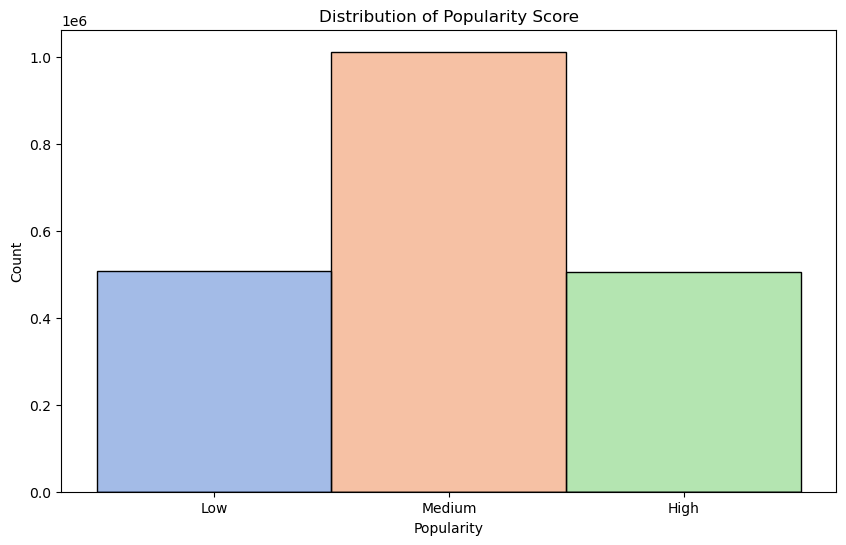

In [96]:
# Presentation Visual
# let's graph the distribution of the popularity score
plt.figure(figsize=(10, 6))

sns.histplot(merged_df, x="popularity", hue="popularity", legend=False, palette="muted")
plt.title("Distribution of Popularity Score")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.xticks([0, 1, 2], ["Low", "Medium", "High"])

plt.show()

### Feature Selection

In [97]:
# see all articles_df cols
merged_df.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id',
       'age', 'postal_code', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc',
       'purchase_count', 'popularity'],
      dtype='object')

In [98]:
# Select relevant features for classification model
merged_df = merged_df.drop(columns=["t_dat", "customer_id", "article_id", "sales_channel_id", "prod_name", "product_type_name", "graphical_appearance_name",
                                        "colour_group_name", "perceived_colour_value_name", "perceived_colour_master_name",
                                        "department_name", "index_name", "index_group_name", "section_name",
                                        "garment_group_name", "detail_desc", "purchase_count"])

merged_df.head()

,price,age,postal_code,product_code,product_type_no,product_group_name,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,popularity
0,0.011847,40.0,0c0e15f8fa88a1d4aa6ca8a0b4a8289ca1affbaebdea22...,743123,298,Swimwear,1010026,9,4,5,4242,B,1,60,1018,low
1,0.011847,40.0,0c0e15f8fa88a1d4aa6ca8a0b4a8289ca1affbaebdea22...,743123,298,Swimwear,1010026,9,4,5,4242,B,1,60,1018,low
2,0.012186,40.0,0c0e15f8fa88a1d4aa6ca8a0b4a8289ca1affbaebdea22...,849597,265,Garment Full body,1010016,53,5,4,2033,A,1,8,1010,low
3,0.016932,40.0,0c0e15f8fa88a1d4aa6ca8a0b4a8289ca1affbaebdea22...,599580,59,Swimwear,1010016,9,4,5,4242,B,1,60,1018,medium
4,0.016932,40.0,0c0e15f8fa88a1d4aa6ca8a0b4a8289ca1affbaebdea22...,599580,59,Swimwear,1010016,9,4,5,4242,B,1,60,1018,medium


## Artificial Neural Network (ANN)
We want to use an ANN and improve it for our recommender model. 74% was the best our previous ANN could do, using LeakyReLU and a laearning rate scheduler (LRS). Let's start with that and try to improve it.

### Train-test split

In [99]:
TARGET = ["popularity"]

X, y = merged_df.drop(columns=TARGET, axis=1), merged_df[TARGET]

In [100]:
# use encoder helper function on the text columns in X
# for easier analysis
helper.encode_strings(X)

In [101]:
# Train test split data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                        train_size=0.7,
                                        test_size=0.3,
                                        random_state=42)

### Tuning: Standard Scaler

In [104]:
# use standard scaler
# check if that will gain better results
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Tuning: ANN

In [105]:
# One-hot encode target variable (for multiclass classification)
y_onehot = pd.get_dummies(y)

In [106]:
# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_onehot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [107]:
# Number of features after preprocessing
input_dim = X_train.shape[1]

# Number of classes (low, medium, high)
output_dim = y_train.shape[1]

input_dim, output_dim

(15, 3)

In [108]:
# Initial model: ANN Model
# with LeakyRelu and learning rate scheduler
# add LeakyReLU with alpha 0.1 to model

ann_model = Sequential([
    Dense(64, input_dim=input_dim),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    Dense(32),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    Dense(output_dim, activation='softmax')
])

# Compile the model
ann_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

ann_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1024      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32)                0         
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 9

In [110]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# create learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [111]:
# Train the model
"""
history = ann_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)
"""

Epoch 1/50
44358/44358 [==============================] - 86s 2ms/step - loss: 160.4316 - accuracy: 0.4335 - val_loss: 1.0684 - val_accuracy: 0.5077 - lr: 0.0010
Epoch 2/50
44358/44358 [==============================] - 80s 2ms/step - loss: 1.0890 - accuracy: 0.4674 - val_loss: 1.0506 - val_accuracy: 0.4994 - lr: 0.0010
Epoch 3/50
44358/44358 [==============================] - 91s 2ms/step - loss: 1.0892 - accuracy: 0.4674 - val_loss: 1.0523 - val_accuracy: 0.4994 - lr: 0.0010
Epoch 4/50
44358/44358 [==============================] - 73s 2ms/step - loss: 1.0875 - accuracy: 0.4682 - val_loss: 1.0803 - val_accuracy: 0.4994 - lr: 0.0010
Epoch 5/50
44358/44358 [==============================] - 59s 1ms/step - loss: 1.0882 - accuracy: 0.4681 - val_loss: 1.0380 - val_accuracy: 0.4993 - lr: 0.0010
Epoch 6/50
44358/44358 [==============================] - 60s 1ms/step - loss: 1.0893 - accuracy: 0.4676 - val_loss: 1.0531 - val_accuracy: 0.4994 - lr: 0.0010
Epoch 7/50
44358/44358 [==============

Commenting this out because it took an hour to run. However, this was the end output: 
`Epoch 50/50 44358/44358 [==============================] - 63s 1ms/step - loss: 0.9622 - accuracy: 0.5380 - val_loss: 0.9534 - val_accuracy: 0.5443 - lr: 3.1250e-05`

In [112]:
# Evaluate on the test set
test_loss, test_accuracy = ann_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.54


9506/9506 [==============================] - 19s 2ms/step
confusion matrix:
 [[ 19961  55075   1083]
 [  9473 139324   3085]
 [  1070  68853   6241]]

              precision    recall  f1-score   support

           0       0.65      0.26      0.37     76119
           1       0.53      0.92      0.67    151882
           2       0.60      0.08      0.14     76164

    accuracy                           0.54    304165
   macro avg       0.59      0.42      0.40    304165
weighted avg       0.58      0.54      0.46    304165



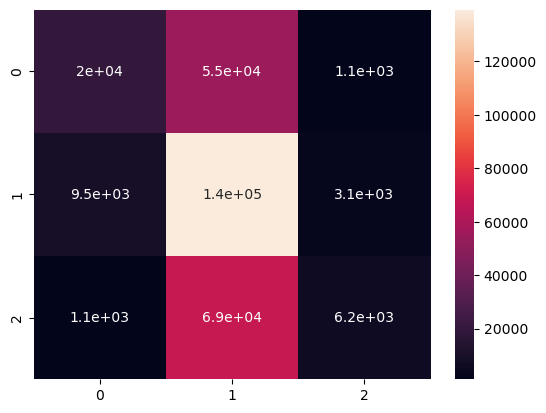

In [113]:
# Predict on test data
y_pred_probs = ann_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Decode the predicted and true labels
y_test_classes = np.argmax(y_test.values, axis=1)

# Confusion Matrix
helper.print_confusion_matrix_details(y_test_classes, y_pred_classes)

### Testing our model with the dataset from the machine learning notebook

In [114]:
# load the modeldata from previous notebook
modeldata_df = pd.read_csv("../data/modeldata_df.csv")
modeldata_df.head()

,product_code,product_type_no,product_group_name,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,popularity
0,108775,253,Garment Upper body,1010016,9,4,5,1676,A,1,16,1002,low
1,108775,253,Garment Upper body,1010016,10,3,9,1676,A,1,16,1002,high
2,108775,253,Garment Upper body,1010017,11,1,9,1676,A,1,16,1002,low
3,110065,306,Underwear,1010016,9,4,5,1339,B,1,61,1017,medium
4,110065,306,Underwear,1010016,10,3,9,1339,B,1,61,1017,medium


In [135]:
modeldata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   product_code                105542 non-null  int64 
 1   product_type_no             105542 non-null  int64 
 2   product_group_name          105542 non-null  object
 3   graphical_appearance_no     105542 non-null  int64 
 4   colour_group_code           105542 non-null  int64 
 5   perceived_colour_value_id   105542 non-null  int64 
 6   perceived_colour_master_id  105542 non-null  int64 
 7   department_no               105542 non-null  int64 
 8   index_code                  105542 non-null  object
 9   index_group_no              105542 non-null  int64 
 10  section_no                  105542 non-null  int64 
 11  garment_group_no            105542 non-null  int64 
 12  popularity                  105542 non-null  object
dtypes: int64(10), object(3)
memor

In [115]:
X_2, y_2 = modeldata_df.drop(columns=TARGET, axis=1), modeldata_df[TARGET]

In [117]:
# use encoder helper function on the text columns in X
# for easier analysis
helper.encode_strings(X_2)

In [120]:
# One-hot encode target variable (for multiclass classification)
y_onehot_2 = pd.get_dummies(y_2)

In [ ]:
# Split data into training, validation, and test sets
X_train_2, X_temp_2, y_train_2, y_temp_2 = train_test_split(X_2, y_onehot_2, test_size=0.3, random_state=42)
X_val_2, X_test_2, y_val_2, y_test_2 = train_test_split(X_temp_2, y_temp_2, test_size=0.5, random_state=42)

In [136]:
# use standard scaler
# check if that will gain better results
scaler = StandardScaler()
X_train_scaled_2 = scaler.fit_transform(X_train_2)
X_val_scaled_2 = scaler.transform(X_val_2)
X_test_scaled_2 = scaler.transform(X_test_2)

In [137]:
# Number of features after preprocessing
input_dim = X_train_scaled_2.shape[1]

# Number of classes (low, medium, high)
output_dim = y_train_2.shape[1]

input_dim, output_dim

(12, 3)

In [ ]:
# Initial model: ANN Model
# with LeakyRelu and learning rate scheduler
ann_model = helper.ANN(input_size=input_dim, hidden_layers=[64, 32], dropouts=[0.3, 0.3], output_size=output_dim, learning_rate=0.001, leaky=True)
ann_model.model_summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                832       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 64)                0         
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32)                0         
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 3)                

'\nann_model = Sequential([\n    Dense(64, input_dim=input_dim),\n    LeakyReLU(alpha=0.1),\n    Dropout(0.3),\n    Dense(32, activation="sigmoid"),\n    LeakyReLU(alpha=0.1),\n    Dropout(0.3),\n    Dense(output_dim, activation=\'softmax\')\n])\n\n# Compile the model\nann_model.compile(optimizer=Adam(learning_rate=0.001),\n              loss=\'categorical_crossentropy\',\n              metrics=[\'accuracy\'])\n\nann_model.summary()\n'

In [ ]:
# Train the model
history = ann_model.train_model(X_train=X_train_scaled_2, y_train=y_train_2,
                      X_validation=X_val_scaled_2, y_validation=y_val_2,
                      epoch=50, batch_size=32)

Epoch 1/50
2309/2309 [==============================] - 7s 2ms/step - loss: 0.6986 - accuracy: 0.7133 - val_loss: 0.6468 - val_accuracy: 0.7380 - lr: 0.0010
Epoch 2/50
2309/2309 [==============================] - 5s 2ms/step - loss: 0.6624 - accuracy: 0.7327 - val_loss: 0.6401 - val_accuracy: 0.7422 - lr: 0.0010
Epoch 3/50
2309/2309 [==============================] - 6s 3ms/step - loss: 0.6556 - accuracy: 0.7362 - val_loss: 0.6364 - val_accuracy: 0.7399 - lr: 0.0010
Epoch 4/50
2309/2309 [==============================] - 7s 3ms/step - loss: 0.6520 - accuracy: 0.7383 - val_loss: 0.6331 - val_accuracy: 0.7435 - lr: 0.0010
Epoch 5/50
2309/2309 [==============================] - 5s 2ms/step - loss: 0.6490 - accuracy: 0.7393 - val_loss: 0.6313 - val_accuracy: 0.7428 - lr: 0.0010
Epoch 6/50
2309/2309 [==============================] - 6s 3ms/step - loss: 0.6486 - accuracy: 0.7380 - val_loss: 0.6318 - val_accuracy: 0.7440 - lr: 0.0010
Epoch 7/50
2309/2309 [==============================] - 5s

'\nhistory = ann_model.fit(\n    X_train_scaled_2, y_train_2,\n    validation_data=(X_val_scaled_2, y_val_2),\n    epochs=50,\n    batch_size=32,\n    callbacks=[early_stopping, lr_scheduler]\n)\n'

In [ ]:
# Evaluate on the test set
ann_model.evaluate_accuracy(X_test=X_test_scaled_2, y_test=y_test_2)

495/495 [==============================] - 1s 2ms/step - loss: 0.6185 - accuracy: 0.7467
Test Accuracy: 0.75


'\ntest_loss, test_accuracy = ann_model.evaluate(X_test_scaled_2, y_test_2, verbose=0)\nprint(f"Test Accuracy: {test_accuracy:.2f}")\n'

495/495 [==============================] - 1s 1ms/step
confusion matrix:
 [[  895   687   368]
 [  114 10145   428]
 [  389  2024   782]]

              precision    recall  f1-score   support

           0       0.64      0.46      0.53      1950
           1       0.79      0.95      0.86     10687
           2       0.50      0.24      0.33      3195

    accuracy                           0.75     15832
   macro avg       0.64      0.55      0.57     15832
weighted avg       0.71      0.75      0.71     15832



'\n# Predict on test data\ny_pred_probs = ann_model.predict(X_test_scaled_2)\ny_pred_classes = np.argmax(y_pred_probs, axis=1)\n\n# Decode the predicted and true labels\ny_test_classes = np.argmax(y_test_2.values, axis=1)\n\n# Confusion Matrix\nhelper.print_confusion_matrix_details(y_test_classes, y_pred_classes)\n'

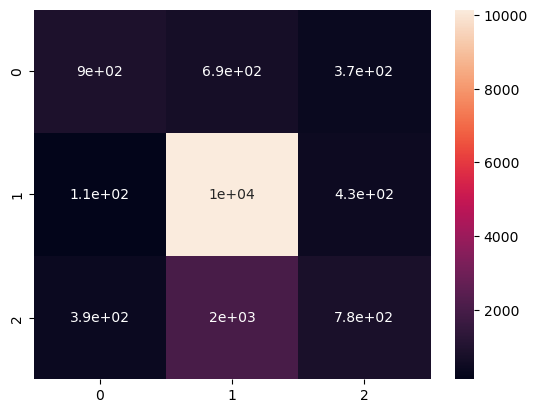

In [ ]:
ann_model.predict_model(X_test=X_test_scaled_2, y_test=y_test_2)

In [ ]:
# recommender system